# Summary

This notebook allows to compare the effect of different levels of diversity on a learner.

# Libraries

In [43]:
import sys

sys.path.append("../")

from src.online_bagging import OnlineBagging

# Preparation

## Dataset

In [44]:
from river.datasets import synth

stream1 = synth.Sine(classification_function=2, balance_classes=True, has_noise=True)
stream2 = synth.Sine(classification_function=0, balance_classes=True, has_noise=True)
dataset = (synth.ConceptDriftStream(stream1, stream2, position=5000, width=3000))
class_list = [0, 1]
n_samples = 12000

## Models

In [45]:
from river import tree

p_classifiers = {"delta": 1e-10}

model1 = tree.HoeffdingTreeClassifier(delta=1e-07)
# model1 = tree.HoeffdingAdaptiveTreeClassifier(p_classifiers)

model2 = OnlineBagging(
    tree.HoeffdingTreeClassifier,
    n_classifiers=10,
    lambda_diversity=1.0,
    p_classifiers={"delta": 1e-02},
    class_list=[0, 1],
)

model3 = OnlineBagging(
    tree.HoeffdingTreeClassifier,
    n_classifiers=10,
    lambda_diversity=0.05,
    p_classifiers=p_classifiers,
    class_list=[0, 1],
)

model4 = OnlineBagging(
    tree.HoeffdingTreeClassifier,
    n_classifiers=10,
    lambda_diversity=0.01,
    p_classifiers=p_classifiers,
    class_list=[0, 1],
)

model5 = OnlineBagging(
    tree.HoeffdingTreeClassifier,
    n_classifiers=10,
    lambda_diversity=0.005,
    p_classifiers=p_classifiers,
    class_list=[0, 1],
)

model_list = [model1, model2, model3, model4, model5]
n_models = len(model_list)

## Metrics

In [46]:
# Metrics
from river import metrics, utils

n_metrics = 1

metrics_list = []
metrics_cum_list = []

for i in range(n_models):
    model_metrics = [utils.Rolling(metrics.Accuracy(), 1000)]

    metrics_list.append(model_metrics)
    metrics_cum_list.append([[] for _ in range(n_metrics)])

# Execution

In [47]:
# Generic loop
for x, y in dataset.take(n_samples):
    for i in range(n_models):
        # Predict and update the model
        y_pred = model_list[i].predict_one(x)
        model_list[i].learn_one(x, y)

        # Update the metrics
        for j in range(n_metrics):
            try:
                metrics_list[i][j].update(y, y_pred)
            except:
                metrics_list[i][j].update(y, class_list[0])
                print("ERROR")
            metrics_cum_list[i][j].append(metrics_list[i][j].get())

# Plotting

Executed 2023-08-26 18:56:28.235212


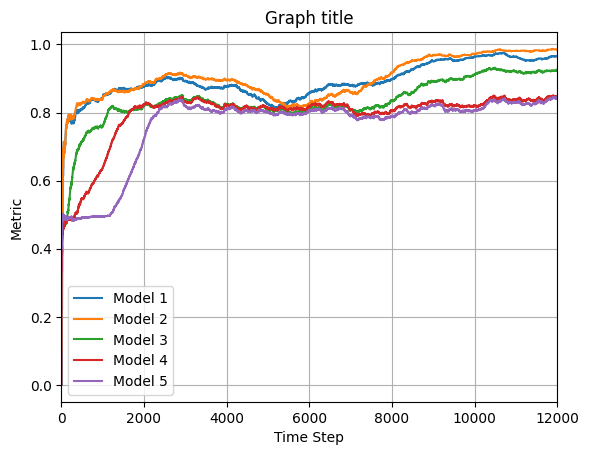

In [50]:
from datetime import datetime
import matplotlib.pyplot as plt

# Plotting
fig, ax = plt.subplots()
for i in range(n_models):
    ax.plot(range(1, n_samples + 1), metrics_cum_list[i][0], label=f"Model {i+1}")
ax.set_xlim(0, n_samples)
#ax.set_ylim(0.5, 1)
ax.set_xlabel("Time Step")
ax.set_ylabel("Metric")
ax.set_title("Graph title")
ax.legend()
ax.grid()
#fig.show()
print(f"Executed {datetime.now()}")